## 필요 모듈 import

In [138]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Dataset 불러오기

In [139]:
(train_datasets, test_datasets), dataset_info = tfds.load(
    name='rock_paper_scissors',
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

train_size = dataset_info.splits['train'].num_examples
test_size = dataset_info.splits['test'].num_examples

dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='tmp/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

## Load 된 Image 확인

In [140]:
def preview_dataset(dataset):
    plt.figure(figsize=(10, 10))
    plot_index = 0
    for features in dataset.take(9):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 3, plot_index)
        label = dataset_info.features['label'].int2str(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

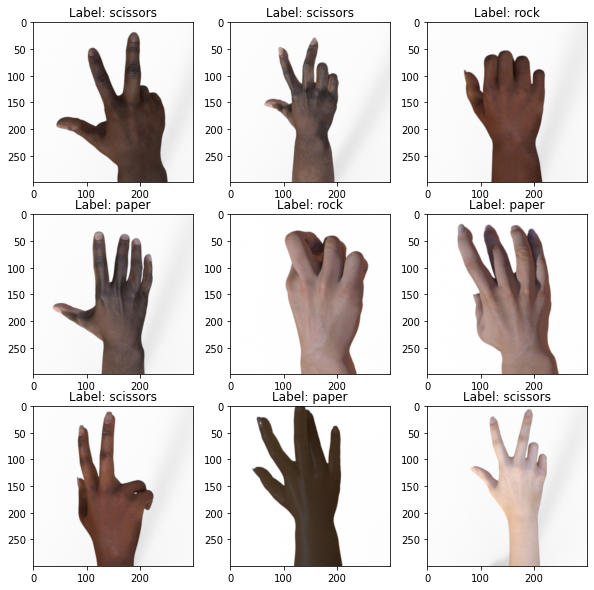

In [141]:
preview_dataset(train_datasets)

## 이미지 전처리

In [142]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, [150, 150])
    return image, label

In [143]:
train_data = train_datasets.map(preprocess)
test_data = test_datasets.map(preprocess)

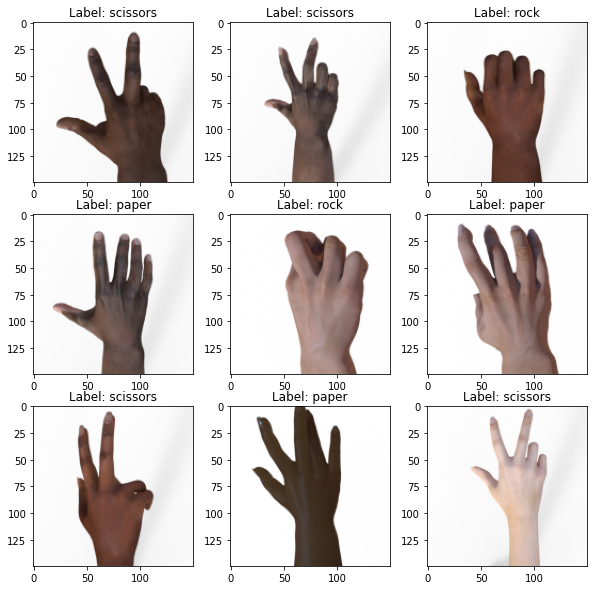

In [144]:
# Explore preprocessed training dataset images.
preview_dataset(train_data)

## Data 증강

In [145]:
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.8)
    image = tf.image.random_brightness(image, 0.03)
    image = tf.image.random_contrast(image, lower=0.5, upper=1)
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image, label

In [146]:
train_data = train_data.map(augment_data)

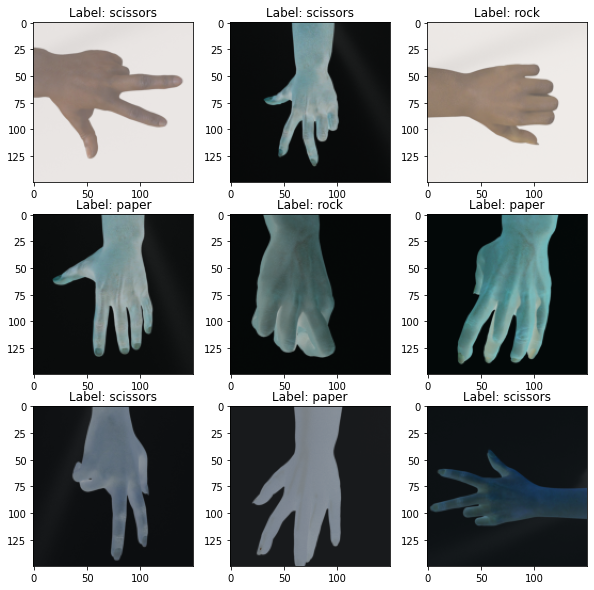

In [147]:
preview_dataset(train_data)

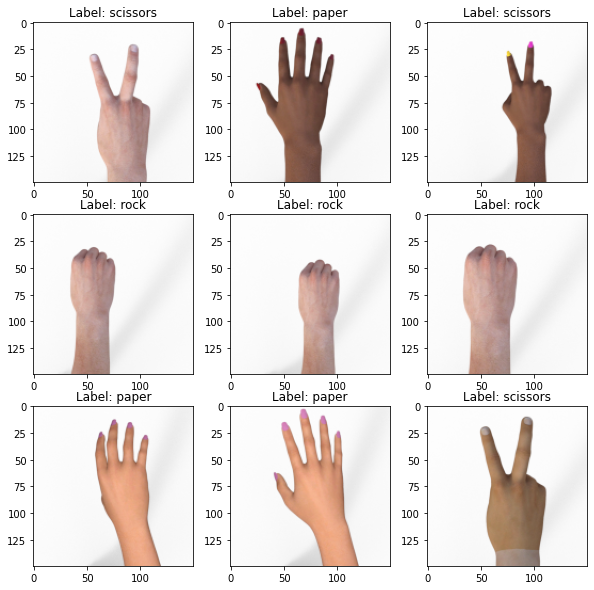

In [148]:
preview_dataset(test_data)

## Batch 설정

In [149]:
batch_size = 32
train_data = train_data.batch(batch_size)
test_data = test_data.batch(batch_size)

## 학습 Model

In [150]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 17, 17, 128)     

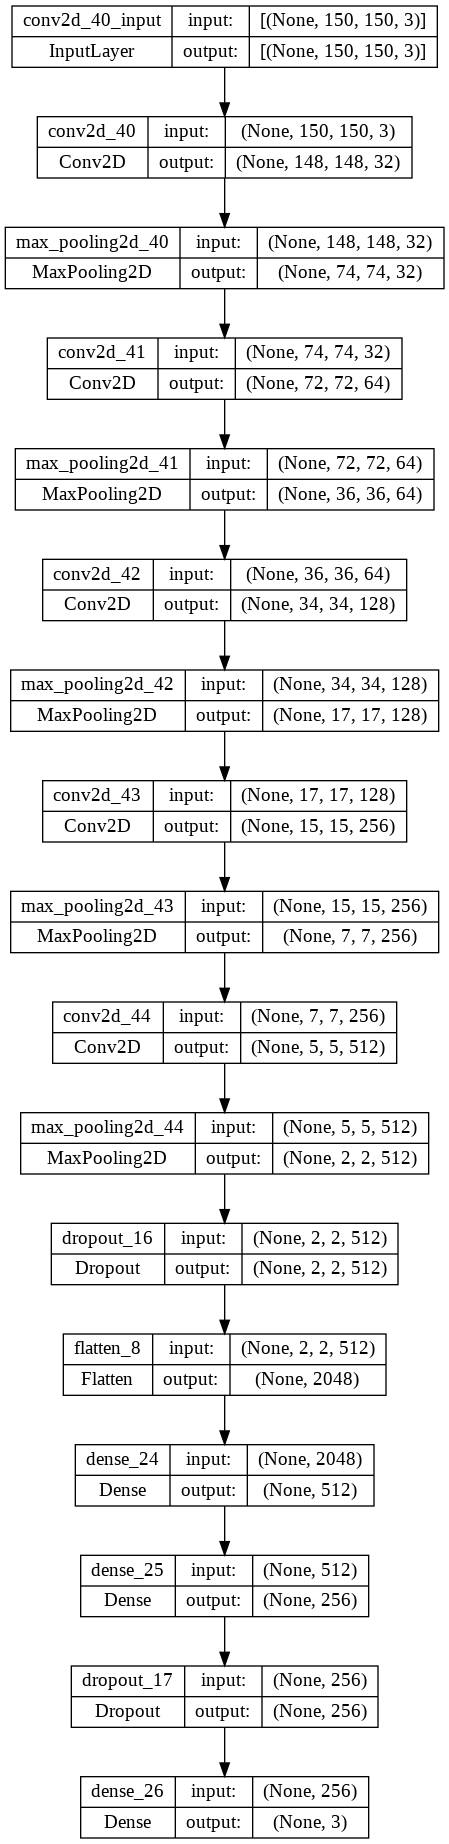

In [151]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Model 학습 및 저장

In [152]:
epoch_step = train_size // batch_size
test_step = test_size // batch_size

checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

history = model.fit(
    train_data.repeat(),
    validation_data=test_data.repeat(),
    steps_per_epoch=epoch_step,
    validation_steps=test_step,
    callbacks=[checkpoint],
    epochs=15,
)

model_name = 'rps.h5'
model.load_weights(checkpoint_path)
model.save(model_name, save_format='h5')

Epoch 1/15
78/78 [==============================] - ETA: 0s - loss: 1.0945 - acc: 0.3466
Epoch 1: val_loss improved from inf to 1.06623, saving model to tmp_checkpoint.ckpt
78/78 [==============================] - 10s 117ms/step - loss: 1.0945 - acc: 0.3466 - val_loss: 1.0662 - val_acc: 0.4347
Epoch 2/15
78/78 [==============================] - ETA: 0s - loss: 0.8806 - acc: 0.6073
Epoch 2: val_loss did not improve from 1.06623
78/78 [==============================] - 5s 61ms/step - loss: 0.8806 - acc: 0.6073 - val_loss: 1.3040 - val_acc: 0.5369
Epoch 3/15
77/78 [============================>.] - ETA: 0s - loss: 0.5997 - acc: 0.7549
Epoch 3: val_loss improved from 1.06623 to 0.61697, saving model to tmp_checkpoint.ckpt
78/78 [==============================] - 5s 62ms/step - loss: 0.5977 - acc: 0.7560 - val_loss: 0.6170 - val_acc: 0.7131
Epoch 4/15
78/78 [==============================] - ETA: 0s - loss: 0.3904 - acc: 0.8565
Epoch 4: val_loss improved from 0.61697 to 0.39572, saving mode

In [153]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['acc']
    val_accuracy = training_history.history['val_acc']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

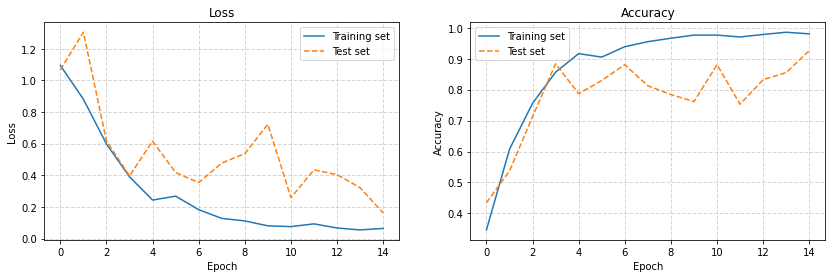

In [154]:
render_training_history(history)